<a href="https://www.advfn.com/nasdaq/nasdaq.asp?companies=A">Nasdaq Stocks</a>

In [1]:
#!python3 best_stock_by_state.py
#!say data ready

In [2]:
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

from best_stock_by_state import get_daily_returns

In [3]:
states = pd.read_csv('../data/hmm_exp_returns.csv')
states = states[['Date', 'state']]
states.index = pd.to_datetime(states.Date)
states.drop(columns='Date', inplace=True)
states.tail()

,state
Date,
2023-02-06,2
2023-02-07,2
2023-02-08,2
2023-02-09,2
2023-02-10,2


In [4]:
states.state.value_counts()

3    6993
0    2563
2    1821
5    1725
1    1122
4     404
Name: state, dtype: int64

In [5]:
STATES = sorted(states.state.unique())
CURRENT_STATE = states.state.to_numpy()[-1]
CURRENT_STATE

2

In [6]:
TOMORROW = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 50
MIN_YEARS = 10
START = TOMORROW - timedelta(YEARS_OF_DATA * 365)

In [7]:
df = pd.read_csv('../data/dar_by_state.csv', index_col=0)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5
ACER,0.997652,0.989656,0.997381,1.004894,0.999361,0.995313,1.001942
ACGL,1.000488,0.997989,1.000362,1.000396,1.000956,1.001284,1.002778
ACHC,1.000012,0.996209,0.999842,0.999710,1.001712,0.994937,1.003390
ACHV,0.998584,0.992225,0.998473,1.001887,0.999017,1.002023,1.003453
ACIW,1.000386,0.993105,0.999557,1.000332,1.002091,1.000545,1.006629


In [8]:
trans = pd.read_csv('../data/transition_probs.csv')
trans

,current_state,next_state,prob
0,2,0,0.026374
1,2,1,0.002747
2,2,2,0.949451
3,2,5,0.021429


In [9]:
trans.prob.sum()

0.9999999999999998

In [10]:
df['weighted'] = 0

for state, prob in zip(trans.next_state, trans.prob):
    df['weighted'] += prob * df[f'dar_{state}']

df = df.sort_values('weighted', ascending=False)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,weighted
BRTX,0.994726,0.991216,1.001127,1.038752,0.992538,0.991347,0.991986,1.036393
CUEN,0.997568,0.992897,0.993737,1.022755,1.002696,1.004529,0.995080,1.021295
NCPL,0.996069,0.991501,0.995080,1.013042,0.996490,1.000184,1.000365,1.012153
LFMD,1.000469,0.994326,1.006844,1.010083,0.999695,0.993851,1.005267,1.009555
BPTH,0.998243,0.994033,0.998214,1.010234,0.999596,0.999218,0.997024,1.009491


In [11]:
df.mean(), df.median()

(dar         1.000113
 dar_0       0.995060
 dar_1       0.999319
 dar_2       1.001037
 dar_3       1.001195
 dar_4       1.001033
 dar_5       1.004082
 weighted    1.000940
 dtype: float64,
 dar         1.000290
 dar_0       0.995129
 dar_1       0.999518
 dar_2       1.001010
 dar_3       1.001237
 dar_4       1.001207
 dar_5       1.004244
 weighted    1.000929
 dtype: float64)

In [79]:
data = None

In [80]:
always_exclude = ['EP', 'NXN', 'NXP']
exclude = {
    0: [],
    1: [],
    2: ['ALTO', 'AMTX', 'BPTH', 'BRTX', 'CPS', 'CUEN', 'ESOA', 'HOUS', 'NCPL', 'RZLT', 'ANGI', 'BXC',
        'FLNT', 'TOVX', 'SVA', 'TTSH', 'TZOO', 'WFCF', 'BTCS', 'FET', 'OBE', 'QRHC', 'CRDF', 'HROW',
        'UIHC', 'RAIL', 'INLX'], #'SPWR',
        #]
    3: [],
    4: [],
    5: [],
    6: [],
    7: []}

In [81]:
best_weighted = [
    s for s in df.index
    if s not in exclude[CURRENT_STATE] + always_exclude
][:20]

In [82]:
print(sorted(best_weighted))
#sorted(best_weighted)

['AREN', 'AXON', 'BB', 'CHUY', 'CSIQ', 'CUBI', 'DYAI', 'ICPT', 'LFMD', 'LIXT', 'OPNT', 'PBF', 'PCRX', 'PFIE', 'RFP', 'SSNT', 'TREE', 'TSLA', 'VTSI', 'WFG']


In [83]:
if data is not None:
    downloaded = list(data)
    for drop in exclude[CURRENT_STATE]:
        if drop in list(data):
            data.drop(columns=[drop], inplace=True)
    needed = [x for x in best_weighted if x not in downloaded]
else:
    needed = best_weighted
    
print(sorted(needed))

['AREN', 'AXON', 'BB', 'CHUY', 'CSIQ', 'CUBI', 'DYAI', 'ICPT', 'LFMD', 'LIXT', 'OPNT', 'PBF', 'PCRX', 'PFIE', 'RFP', 'SSNT', 'TREE', 'TSLA', 'VTSI', 'WFG']


In [84]:
keep_col = needed[0] if len(needed) == 1 else 'AdjClose'
get = (
    yf
    .download(needed, start=START, end=TOMORROW)
    .rename(columns={'Adj Close': keep_col}))[keep_col]
if data is not None:
    data = pd.concat([data, get], axis=1)
else:
    data = get

[*********************100%***********************]  20 of 20 completed


In [85]:
data.index = pd.to_datetime(data.index)
data = data.sort_index()
data.tail()

,AREN,AXON,BB,CHUY,CSIQ,CUBI,DYAI,ICPT,LFMD,LIXT,OPNT,PBF,PCRX,PFIE,RFP,SSNT,TREE,TSLA,VTSI,WFG
Date,,,,,,,,,,,,,,,,,,,,
2023-02-06,10.76,195.949997,4.41,33.759998,40.549999,32.080002,1.72,20.660000,2.16,0.81,20.799999,38.209999,41.240002,1.10,21.750000,3.49,43.230000,194.759995,4.7800,85.059998
2023-02-07,10.38,188.580002,4.44,34.000000,40.110001,32.599998,1.51,21.709999,2.03,1.89,21.030001,40.509998,41.599998,1.15,21.600000,3.50,46.049999,196.809998,4.8000,87.309998
2023-02-08,9.55,185.000000,4.37,33.610001,39.689999,32.279999,1.54,20.750000,2.03,1.26,21.100000,40.020000,40.880001,1.14,21.600000,3.43,45.099998,201.289993,4.7599,85.959999
2023-02-09,9.04,183.809998,4.22,32.689999,40.099998,32.150002,1.54,20.840000,1.89,1.09,20.809999,39.720001,40.090000,1.16,21.650000,3.41,44.590000,207.320007,4.7900,85.050003
2023-02-10,9.05,184.550003,4.11,32.139999,40.320000,31.959999,1.58,20.860001,1.85,1.20,21.100000,42.270000,39.950001,1.17,21.690001,3.48,43.599998,196.889999,4.7400,85.250000


In [86]:
if 'state' not in list(data):
    data = pd.concat([data, states], axis=1)
data.tail()

,AREN,AXON,BB,CHUY,CSIQ,CUBI,DYAI,ICPT,LFMD,LIXT,...,PBF,PCRX,PFIE,RFP,SSNT,TREE,TSLA,VTSI,WFG,state
Date,,,,,,,,,,,,,,,,,,,,,
2023-02-06,10.76,195.949997,4.41,33.759998,40.549999,32.080002,1.72,20.660000,2.16,0.81,...,38.209999,41.240002,1.10,21.750000,3.49,43.230000,194.759995,4.7800,85.059998,2
2023-02-07,10.38,188.580002,4.44,34.000000,40.110001,32.599998,1.51,21.709999,2.03,1.89,...,40.509998,41.599998,1.15,21.600000,3.50,46.049999,196.809998,4.8000,87.309998,2
2023-02-08,9.55,185.000000,4.37,33.610001,39.689999,32.279999,1.54,20.750000,2.03,1.26,...,40.020000,40.880001,1.14,21.600000,3.43,45.099998,201.289993,4.7599,85.959999,2
2023-02-09,9.04,183.809998,4.22,32.689999,40.099998,32.150002,1.54,20.840000,1.89,1.09,...,39.720001,40.090000,1.16,21.650000,3.41,44.590000,207.320007,4.7900,85.050003,2
2023-02-10,9.05,184.550003,4.11,32.139999,40.320000,31.959999,1.58,20.860001,1.85,1.20,...,42.270000,39.950001,1.17,21.690001,3.48,43.599998,196.889999,4.7400,85.250000,2


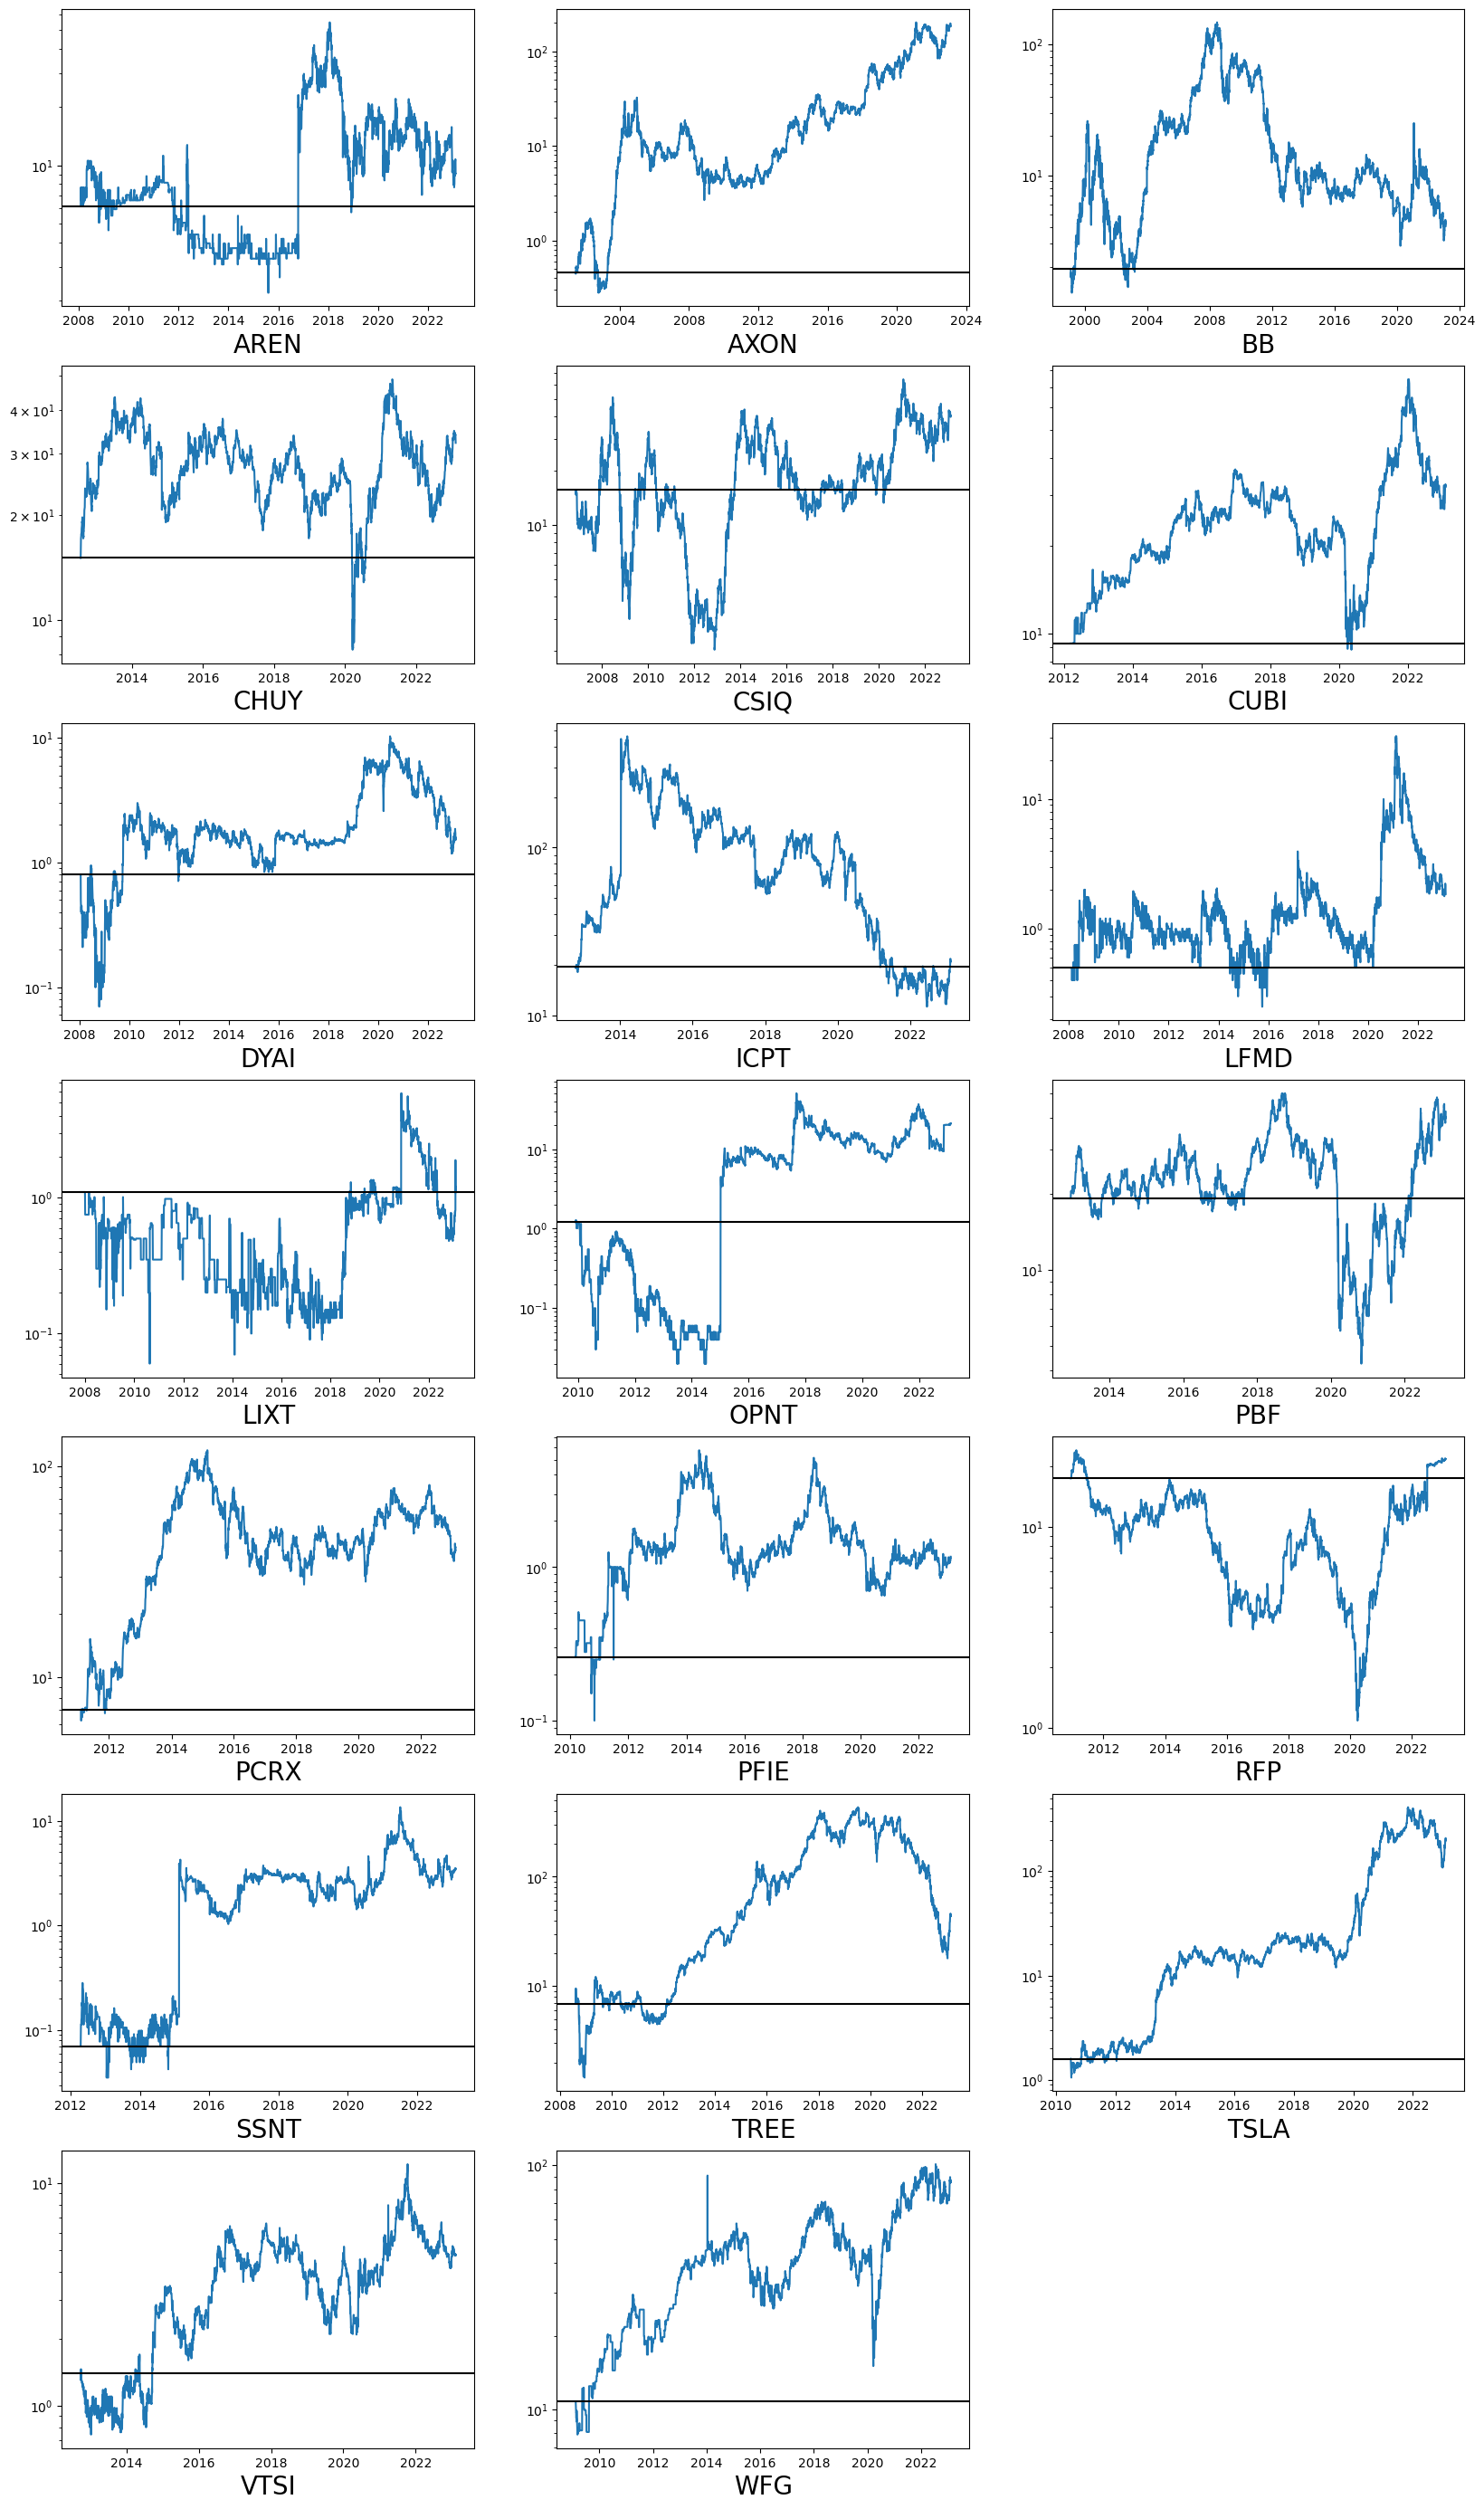

In [87]:
plt.rc('axes', labelsize=20)
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    x = data[sym]
    x = x[x.notnull()]
    plt.subplot(7, 3, i + 1)
    plt.plot(x)
    plt.axhline(y=x[0], color='k')
    plt.xlabel(sym)
    plt.yscale('log');

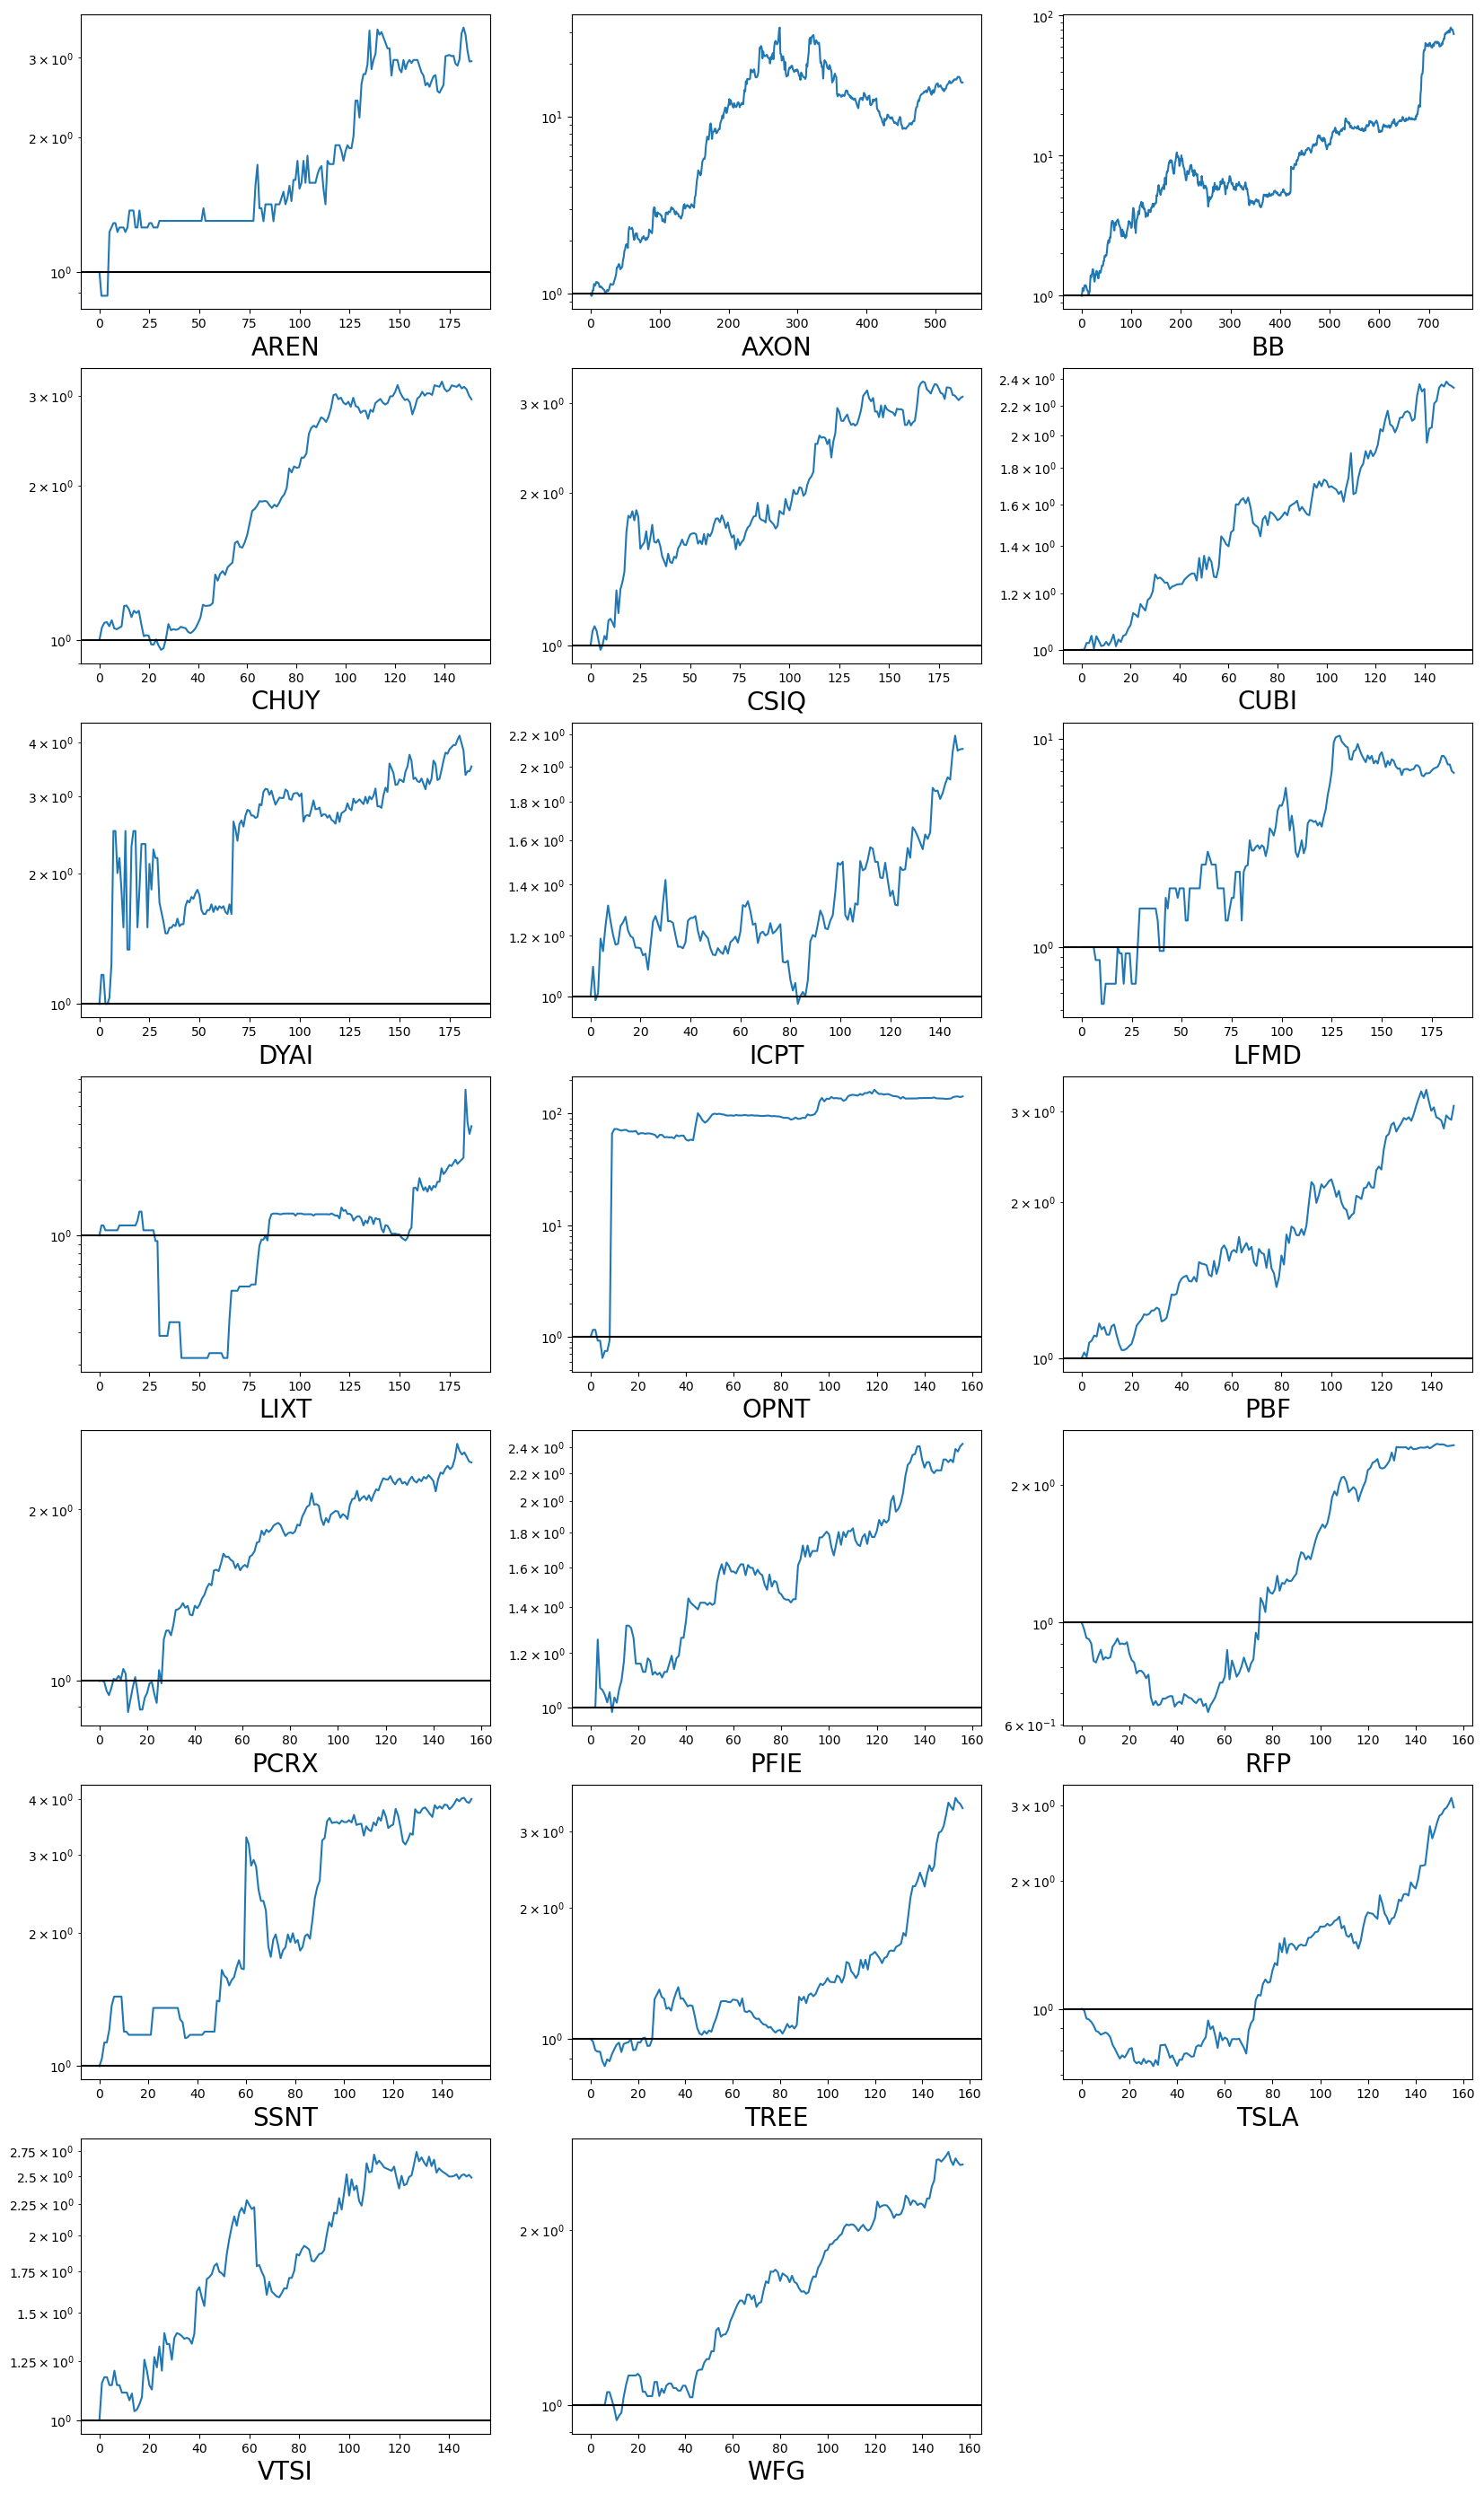

In [88]:
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    plt.subplot(7, 3, i + 1)
    dr = get_daily_returns(data[sym])
    dr = dr[data.state == CURRENT_STATE]
    dr = dr[dr.notnull()]
    dr = (dr + 1).to_numpy()
    dr = np.array([1] + list(dr))
    plt.plot(dr.cumprod())
    plt.axhline(y=dr[0], color='k')
    plt.yscale('log')
    plt.xlabel(sym);